In [215]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_jsonl

pd.options.display.float_format = "{:.0f}".format

In [243]:
tournament = "tournaments/rakuda_koukou_v0_tournament"
# tournament = ''
if not tournament:
    from elo import Bot, EloRanker, Referee, load_jsonl

    bots = [
        Bot("GPT3", "answers/rakuda_koukou_v0/gpt3.jsonl"),
        Bot("Rinna 3.6B - PPO", "answers/rakuda_koukou_v0/rinna-ppo.jsonl"),
        Bot("Rinna 3.6B - SFTv2", "answers/rakuda_koukou_v0/rinna-sft.jsonl"),
        Bot("Rinna 3.6B", "answers/rakuda_koukou_v0/rinna.jsonl"),
        Bot("Open Calm 7B - Stormy", "answers/rakuda_koukou_v0/stormy.jsonl"),
        Bot("Open Calm 7B", "answers/rakuda_koukou_v0/calm.jsonl"),
    ]

    referee = Referee(
        "matchups/rakuda_koukou_v0.jsonl",
        "prompts/rakuda_reviewer.jsonl",
        "prompts/rakuda_prompt_threeclass.jsonl",
        max_tokens=1024,
        model="gpt-3.5-turbo-0301",
    )

    ranker = EloRanker(bots, "questions/rakuda_koukou_v0.jsonl", referee, verbose=True)
    ranker.run_tournament(100)

    ranker.output_standings("tournaments/rakuda_koukou_v0_tournament_result.jsonl")
    ranker.output_tournament("tournaments/rakuda_koukou_v0_tournament.jsonl")
    tournament = "tournaments/rakuda_koukou_v0_tournament"

## The tournament standings

In [244]:
standings = pd.DataFrame(load_jsonl(tournament + "_result.jsonl"))
standings.head()

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,GPT3,1403,107,1311,1386,1444,58,75
1,Open Calm 7B - Stormy,976,106,873,963,1052,90,90
2,Open Calm 7B,947,106,882,974,1068,94,92
3,Rinna 3.6B - SFTv2,912,107,827,917,1004,87,89
4,Rinna 3.6B - PPO,884,108,815,901,988,87,86


## Dataframe containing all results

In [245]:
results = pd.DataFrame(load_jsonl(tournament + ".jsonl"))
results.head(1)

,bot1,bot2,prematch_elo1,prematch_elo2,question,question_id,response1,response2,referee_comments,score,postmatch_elo1,postmatch_elo2
0,Rinna 3.6B - PPO,GPT3,1000,1000,北海道の主要な都市5つを挙げ、それぞれの地理的特徴について簡単に説明してください。,27,もちろんです。北海道の主要都市には、札幌、函館、小樽、釧路、帯広があります。これらの地域は、...,はい、北海道の主要な都市5つは、札幌市、旭川市、帯広市、函館市、釧路市です。\n\n1. 札...,アシスタント1の回答は、地理的特徴についての詳細な説明がなく、情報が不足しているため、評価は...,2,984,1016


## Evolution across the tournament

In [246]:
import matplotlib.pyplot as plt

elos = {}
for bot in results.bot1.unique():
    bot_elos = [1000]
    for i, result in results.iterrows():
        if result["bot1"] == bot:
            bot_elos.append(result["postmatch_elo1"])
        elif result["bot2"] == bot:
            bot_elos.append(result["postmatch_elo2"])
        else:
            pass
    elos.update({bot: bot_elos})

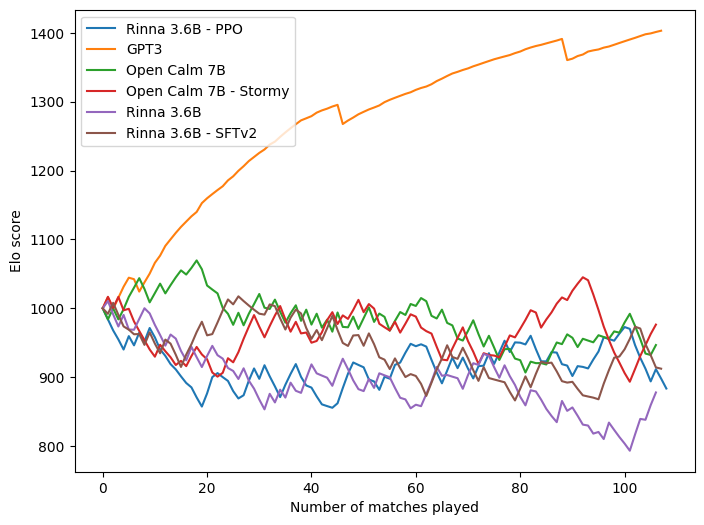

In [247]:
fig, ax = plt.subplots(figsize=(8, 6))
for k, v in elos.items():
    ax.plot(v, label=k)
ax.legend(loc="upper left")
ax.set_xlabel("Number of matches played")
ax.set_ylabel("Elo score")
plt.show()

## Results distribution

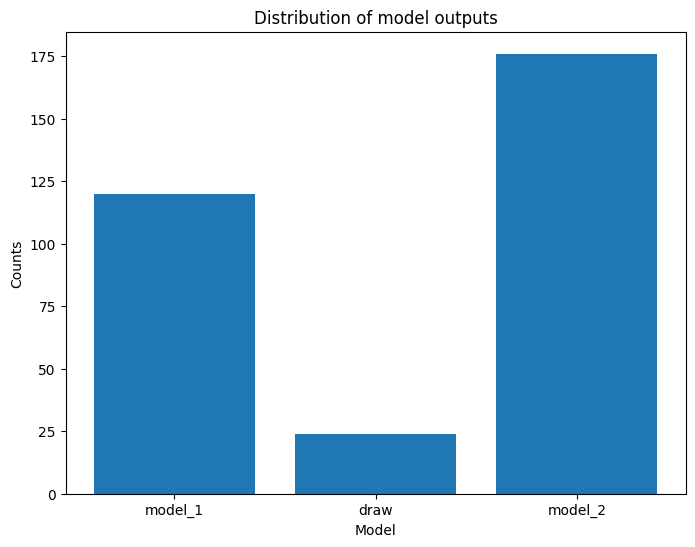

In [249]:
df = results["score"].value_counts()

# Order DataFrame by result
df = df.loc[[1, 3, 2]].reset_index()

# Define labels
labels = ["model_1", "draw", "model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"])
ax.set_xlabel("Model")
ax.set_ylabel("Counts")
ax.set_title("Distribution of model outputs")
plt.show()

## Head to head results

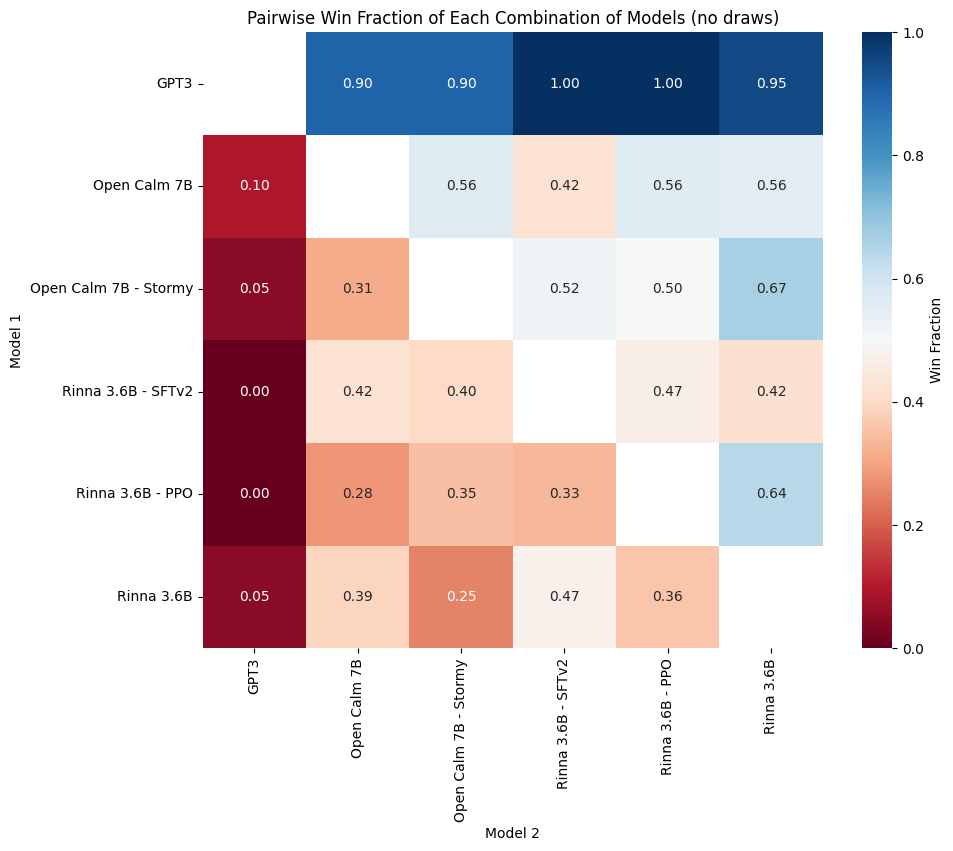

In [250]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def compute_pairwise_win_fraction(battles):
    all_models = list(set(battles["bot1"]).union(battles["bot2"]))
    empty_df = pd.DataFrame(0, index=all_models, columns=all_models)

    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 1],
        index="bot1",
        columns="bot2",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    a_win_ptbl = empty_df.add(a_win_ptbl, fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 2],
        index="bot1",
        columns="bot2",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    b_win_ptbl = empty_df.add(b_win_ptbl, fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(
        battles, index="bot1", columns="bot2", aggfunc="size", fill_value=0
    )

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (a_win_ptbl + b_win_ptbl.T) / (
        num_battles_ptbl + num_battles_ptbl.T
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col


def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(
        row_beats_col,
        annot=True,
        fmt=".2f",
        cmap="RdBu",
        cbar_kws={"label": "Win Fraction"},
    )
    ax.set_title(title)
    ax.set_xlabel("Model 2")
    ax.set_ylabel("Model 1")

    # plt.savefig("pairwise_win_fraction.png")
    plt.show()


visualize_pairwise_win_fraction(
    results, title="Pairwise Win Fraction of Each Combination of Models (no draws)"
)

## Confirm elo computation was performed properly

In [251]:
from collections import defaultdict


def compute_elo(battles, K=32, SCALE=400, BASE=10, INIT_RATING=1000):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, win in battles[["bot1", "bot2", "score"]].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))
        if win == 1:
            sa = 1
        elif win == 2:
            sa = 0
        elif win == 3:
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {win}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    rating = dict(sorted(rating.items(), key=lambda item: item[1], reverse=True))
    return rating

In [252]:
assert all(
    [
        round(row["elo"], 6) == round(compute_elo(results)[row["model"]], 6)
        for i, row in standings.iterrows()
    ]
)

# Predict win rate

In [253]:
def predict_win_rate(standings, K=32, SCALE=400, BASE=10, INIT_RATING=1000):
    names = sorted(list(standings["model"]))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (
                1
                + BASE
                ** (
                    (
                        standings.loc[standings["model"] == b, "elo"].values[0]
                        - standings.loc[standings["model"] == a, "elo"].values[0]
                    )
                    / SCALE
                )
            )
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {a: [wins[a][b] if a != b else np.NAN for b in names] for a in names}

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

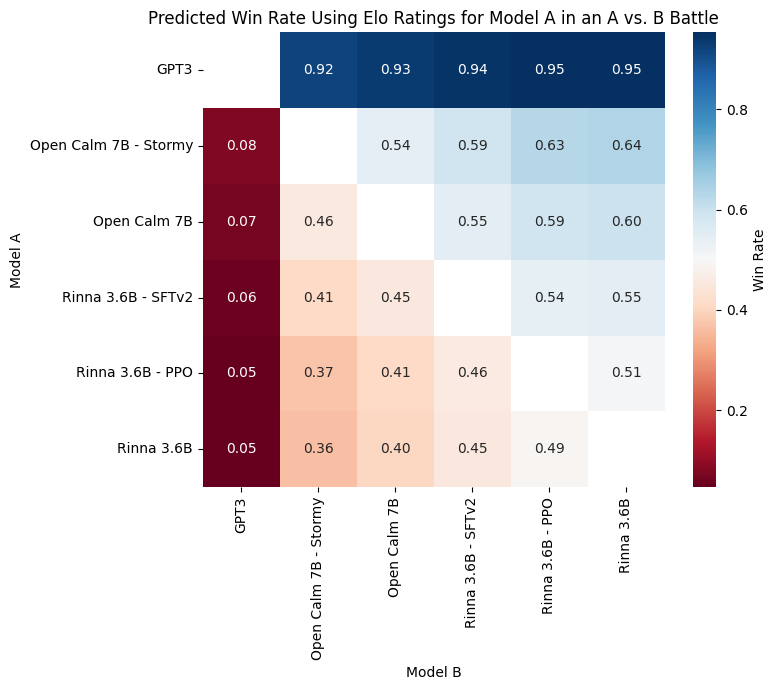

In [257]:
win_rate = predict_win_rate(standings)

ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
ordered_win_rate = win_rate.loc[ordered_models, ordered_models]

fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(
    ordered_win_rate, annot=True, fmt=".2f", cmap="RdBu", cbar_kws={"label": "Win Rate"}
)
ax.set_title("Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle")
ax.set_xlabel("Model B")
ax.set_ylabel("Model A")
plt.tight_layout()
# plt.savefig('elo_predicted_win_rate.png')
plt.show()

### Check bootstrap confidence intervals were properly computed

Here we use bootstrap to estimate the confidence intervals

In [258]:
def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]


BOOTSTRAP_ROUNDS = 10000

bootstrap_elo_lu = get_bootstrap_result(results, compute_elo, BOOTSTRAP_ROUNDS)
bootstrap_elo_lu

bootstrap: 100%|██████████| 10000/10000 [00:14<00:00, 698.76it/s]


,GPT3,Open Calm 7B,Open Calm 7B - Stormy,Rinna 3.6B - SFTv2,Rinna 3.6B - PPO,Rinna 3.6B
0,1310,988,1019,888,922,873
1,1397,1051,880,962,910,801
2,1393,1038,829,908,939,893
3,1346,978,925,970,905,875
4,1350,1016,919,962,894,859
...,...,...,...,...,...,...
9995,1397,978,977,925,845,878
9996,1378,904,998,864,861,996
9997,1361,935,1051,894,905,853
9998,1426,1046,880,911,943,793


In [260]:
bootstrap_elo = (
    pd.DataFrame(
        dict(
            lower=bootstrap_elo_lu.quantile(0.025),
            median=bootstrap_elo_lu.quantile(0.5),
            upper=bootstrap_elo_lu.quantile(0.975),
        )
    )
    .reset_index()
    .rename(columns={"index": "model"})
    .sort_values("median", ascending=False)
)
bootstrap_elo["error_y_plus"] = bootstrap_elo["upper"] - bootstrap_elo["median"]
bootstrap_elo["error_y_minus"] = bootstrap_elo["median"] - bootstrap_elo["lower"]

In [261]:
bootstrap_elo

,model,lower,median,upper,error_y_plus,error_y_minus
0,GPT3,1313,1386,1442,56,73
1,Open Calm 7B,884,975,1069,94,90
2,Open Calm 7B - Stormy,871,963,1052,89,92
3,Rinna 3.6B - SFTv2,825,917,1004,87,92
4,Rinna 3.6B - PPO,813,900,990,90,87
5,Rinna 3.6B,768,861,956,95,94


In [262]:
standings

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,GPT3,1403,107,1311,1386,1444,58,75
1,Open Calm 7B - Stormy,976,106,873,963,1052,90,90
2,Open Calm 7B,947,106,882,974,1068,94,92
3,Rinna 3.6B - SFTv2,912,107,827,917,1004,87,89
4,Rinna 3.6B - PPO,884,108,815,901,988,87,86
5,Rinna 3.6B,878,106,770,861,959,97,91


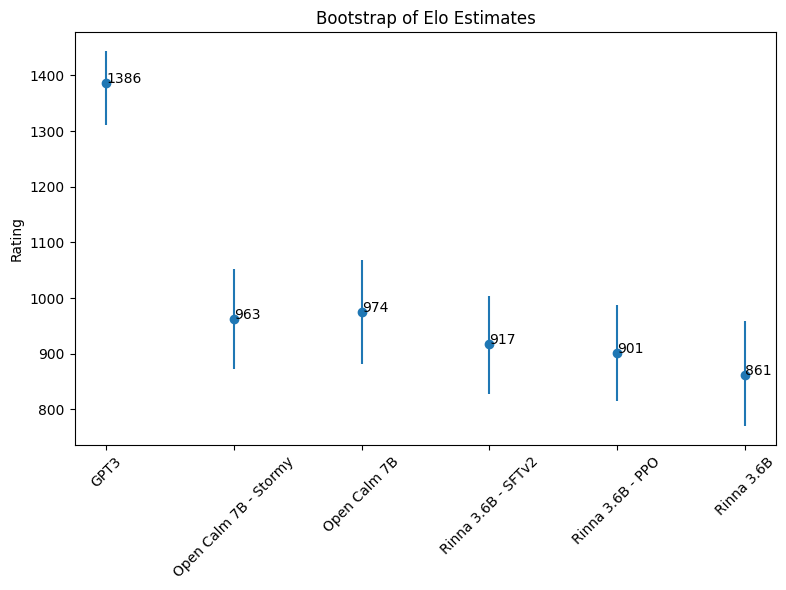

In [267]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    standings["model"],
    standings["median"],
    yerr=[standings["error_y_minus"], standings["error_y_plus"]],
    fmt="o",
)
for i, txt in enumerate(standings["median"]):
    ax.annotate(round(txt), (standings["model"][i], standings["median"][i]))
ax.set_title("Bootstrap of Elo Estimates")
ax.set_ylabel("Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plt.savefig('bootstrap_elo_estimates.png')
# plotly version
#
# fig = px.scatter(bootstrap_elo, x="model", y="median", error_y="error_y",
#                   error_y_minus="error_y_minus", text="median_rounded",
#                   title="Bootstrap of Elo Estimates")
# fig.update_layout(xaxis_title="Model", yaxis_title="Rating")
# fig.write_html("bootstrap_elo_estimates.html", full_html=False, include_plotlyjs="cdn")
# fig

### Add bootstrap error estimate to time evolution plot

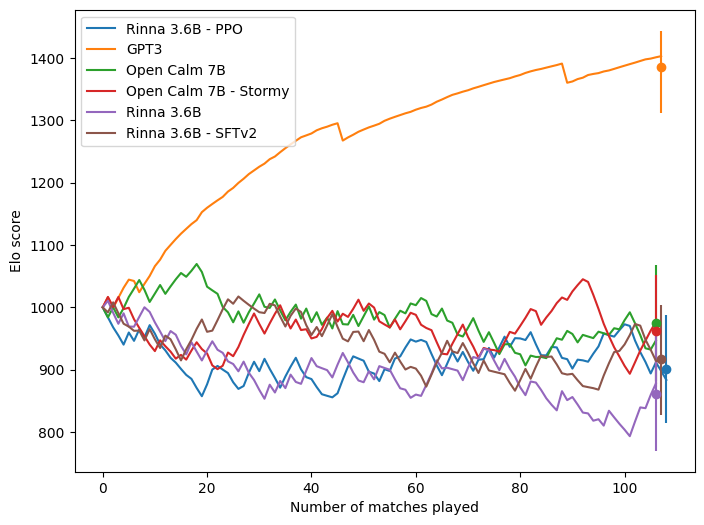

In [269]:
import matplotlib.pyplot as plt

elos = {}
for bot in results.bot1.unique():
    bot_elos = [1000]
    for i, result in results.iterrows():
        if result["bot1"] == bot:
            bot_elos.append(result["postmatch_elo1"])
        elif result["bot2"] == bot:
            bot_elos.append(result["postmatch_elo2"])
        else:
            pass
    elos.update({bot: bot_elos})

fig, ax = plt.subplots(figsize=(8, 6))

standings = standings.set_index("model")
for k, v in elos.items():
    line = ax.plot(v, label=k)
    if k in standings.index:  # check if the model has bootstrap estimates
        # plt.errorbar(len(v) - 1, v[-1],
        #              yerr=[[bootstrap_elo.loc[k, 'error_y_minus']],
        #                    [bootstrap_elo.loc[k, 'error_y']]],
        #              fmt='o',color=line[0].get_color())
        ax.errorbar(
            len(v) - 1,
            standings.loc[k, "median"],
            yerr=[
                [standings.loc[k, "error_y_minus"]],
                [standings.loc[k, "error_y_plus"]],
            ],
            fmt="o",
            color=line[0].get_color(),
        )
standings = standings.reset_index()
ax.set_xlabel("Number of matches played")
ax.set_ylabel("Elo score")
plt.legend()